In [75]:
from __future__ import absolute_import, division, print_function
import multiprocessing
import os
import re
import gensim
import gensim.models.word2vec as w2v
import sklearn.manifold
import pandas as pandas
import seaborn as sns
import collections
from encodings.utf_16 import decode
from codecs import ignore_errors
import matplotlib.pyplot as plt
import tensorflow as tf
import shutil
import smart_open
from sys import platform
from nltk.tokenize import word_tokenize
%pylab inline

Populating the interactive namespace from numpy and matplotlib


c:\users\akhil\appdata\local\programs\python\python36\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['text', 'seed']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [30]:
def prepend_line(infile, outfile, line):
    with open(infile, 'r', encoding='ISO-8859-1') as old:
        with open(outfile, 'w', encoding='ISO-8859-1') as new:
            new.write(str(line) + "\n")
            shutil.copyfileobj(old, new)

def prepend_slow(infile, outfile, line):
    with open(infile, 'r', encoding='ISO-8859-1') as fin:
        with open(outfile, 'w', encoding='ISO-8859-1') as fout:
            fout.write(line + "\n")
            for line in fin:
                fout.write(line)

def get_lines(glove_file_name):
    with open(glove_file_name, encoding='ISO-8859-1') as f:
        num_lines = sum(1 for line in f)
    with open(glove_file_name, encoding='ISO-8859-1') as f:
        num_dims = len(f.readline().split()) - 1
    return num_lines, num_dims

glove_file="glove.42B.300d.txt"
num_lines, dims = get_lines(glove_file)

gensim_file='glove_model.txt'
gensim_first_line = "{} {}".format(num_lines, dims)

if platform == "linux" or platform == "linux2":
     prepend_line(glove_file, gensim_file, gensim_first_line)
else:
     prepend_slow(glove_file, gensim_file, gensim_first_line)

glove_embeddings = gensim.models.KeyedVectors.load_word2vec_format(gensim_file,binary=False)

print (glove_embeddings.most_similar(positive=['solitude'], topn=10))
print (glove_embeddings.similarity('gold', 'silver'))
print (glove_embeddings.similarity('gold', 'water'))

[('tranquility', 0.6253386735916138), ('seclusion', 0.5990118980407715), ('stillness', 0.5978003740310669), ('silence', 0.5931397676467896), ('tranquillity', 0.5844762921333313), ('quietness', 0.5827533006668091), ('loneliness', 0.581436812877655), ('serenity', 0.5574653148651123), ('contemplation', 0.5377521514892578), ('solace', 0.5191237330436707)]
0.866302191315
0.391078300469


In [31]:
training_data = pandas.read_csv('train.csv', encoding='ISO-8859-1')
author_labels = training_data.author
labels = np.zeros(shape=(len(author_labels)), dtype=np.int32)
for i in range(len(author_labels)):
    if author_labels[i] == 'EAP':
        labels[i] = 0
    elif author_labels[i] == 'HPL':
        labels[i] = 1
    else:
        labels[i] = 2

text = training_data.text
words = []
sentences = []
unique_words = []
num_samples = len(text)

for text_index in range(0, num_samples):
    words.append(word_tokenize(text[text_index]))

def sentence_to_wordlist(raw):
    return word_tokenize(raw)

for raw_sentence in text:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

num_features = 300
min_word_count = 3
num_workers = multiprocessing.cpu_count()
context_size = 7
downsampling = 1e-3
seed = 1
epochs = 100
tr_data_embeddings = w2v.Word2Vec(
     sg=1,
     seed=seed,
     workers=num_workers,
     size=num_features,
     min_count=min_word_count,
     window=context_size,
     sample=downsampling
)
tr_data_embeddings.build_vocab(sentences)
tr_data_embeddings.train(sentences, num_samples, epochs = epochs)

if not os.path.exists("trained-embeddings"):
     os.makedirs("trained-embeddings")
tr_data_embeddings.save(os.path.join("trained-embeddings", "tr_data_embeddings.w2v"))

tr_data_embeddings = w2v.Word2Vec.load(os.path.join("trained-embeddings", "tr_data_embeddings.w2v"))
print (tr_data_embeddings.most_similar(positive=['solitude'], topn=10))
print (tr_data_embeddings.similarity('gold', 'silver'))
print (tr_data_embeddings.similarity('gold', 'water'))

[('fortress', 0.3363228440284729), ('weariness', 0.33105236291885376), ('deplorable', 0.3239361047744751), ('smiles', 0.3148871660232544), ('longing', 0.31083738803863525), ('changeful', 0.31035420298576355), ('insensibility', 0.30786454677581787), ('reconcile', 0.30653008818626404), ('turmoil', 0.3004745841026306), ('prolong', 0.29997456073760986)]
0.210124434965
0.072658927689


In [34]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

all_word_vectors_matrix = tr_data_embeddings.syn0_lockf
all_word_vectors_matrix=all_word_vectors_matrix.reshape(-1,1)
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

points = pandas.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[word2vec.wv.vocab[word].index])
            for word in word2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)
points.head(10)

,word,x,y
0,This,0.203218,0.237778
1,process,0.605538,0.065136
2,",",0.088622,0.108276
3,however,0.889821,-1.047365
4,afforded,0.413507,-0.196301
5,me,0.088596,0.108276
6,no,0.193878,0.668906
7,means,-0.355137,0.105490
8,of,0.088615,0.108281
9,ascertaining,0.753510,1.199690


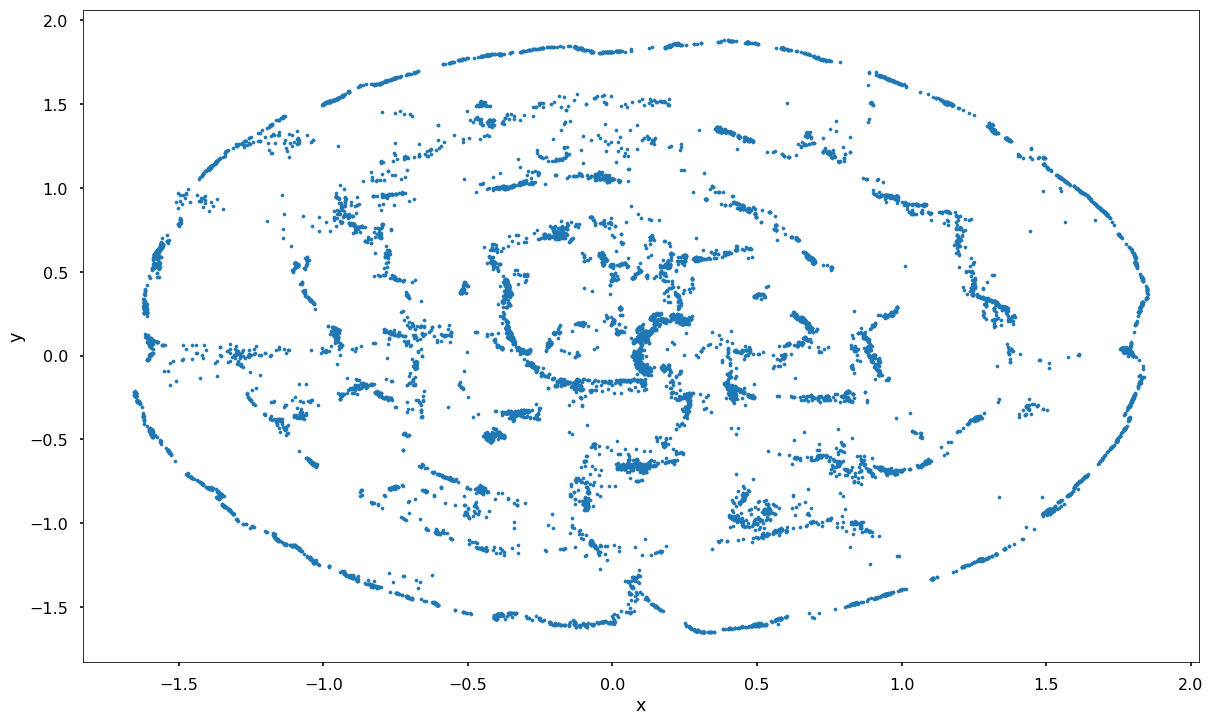

In [72]:
sns.set_context("poster")
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

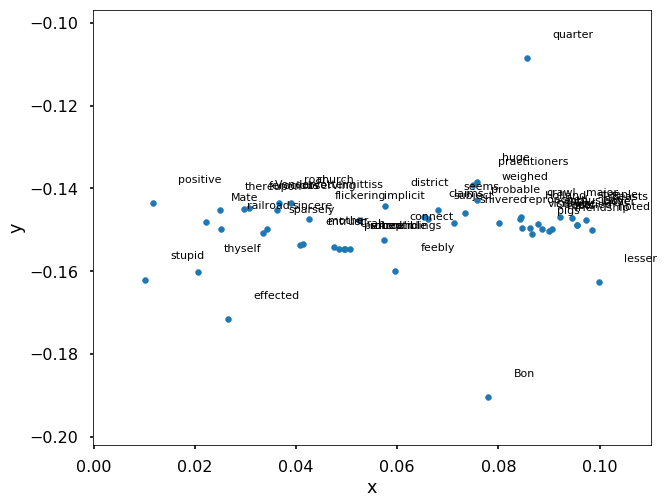

In [73]:
def zoom_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

zoom_region(x_bounds=(0, 0.1), y_bounds=(-0.2, -0.1))

In [74]:
test_data = pandas.read_csv('test.csv', encoding='ISO-8859-1')
test_text = test_data.text
test_words = []

for text_index in range(0, len(test_text)):
    test_words.append(word_tokenize(test_text[text_index]))